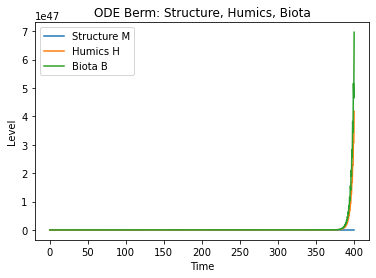

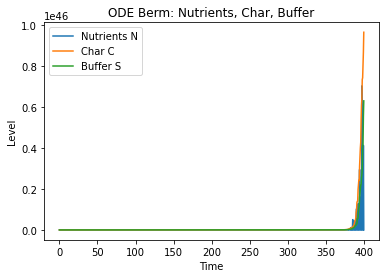

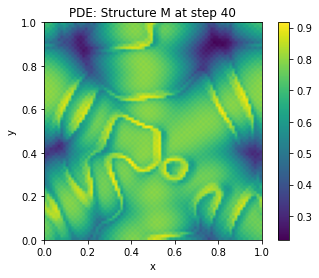

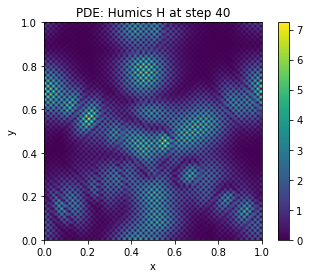

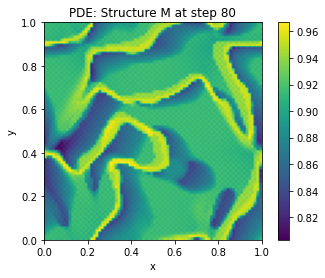

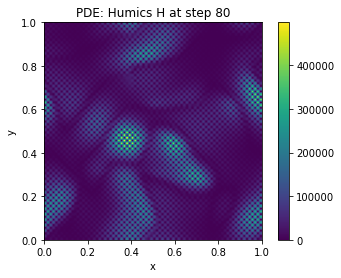

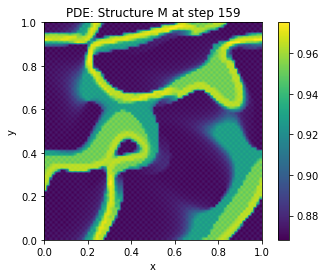

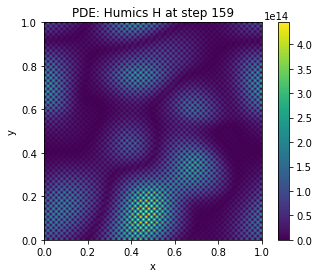

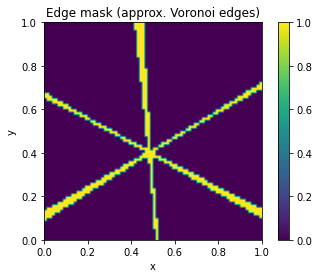

Saved outputs: summary.json pde_final_fields.npz


In [1]:
# Terra Preta Berm RAF Simulator (ODE + 2D PDE toy)
# - ODE: lumped berm reactor with stigmergic inputs
# - PDE: 2D grid with nearest-edge deposition (Voronoi-like edges) and simple diffusion/advection
#
# Notes:
# - Uses matplotlib with one plot per figure and no explicit color selections (per instructions).
# - Keeps grid and steps modest for speed in this environment.

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# A) Lumped ODE model
# -----------------------------

def simulate_ode(T=400, dt=0.5, seed=0):
    rng = np.random.default_rng(seed)
    # Parameters (dimensionless, illustrative)
    mu_B, d_B = 0.6, 0.2
    y_H, d_H = 0.4, 0.01
    l_N = 0.5
    alpha_C, alpha_H = 2.0, 1.5
    k_C, k_S = 0.001, 0.002
    gamma_M, K_B, beta_C, beta_H, delta_M = 0.5, 0.1, 0.8, 0.8, 0.05
    K_N, K_S, K_C, K_H = 0.2, 0.3, 0.3, 0.3
    beta_S = 1.0
    
    # Mean inputs
    uC_mean, uN_mean, uS_mean = 0.05, 0.2, 0.03
    # Stigmergy
    kappa = 0.5
    a1, a2, a3 = 1.0, 0.5, 0.25  # visibility weights
    
    # State arrays
    steps = int(T/dt)
    C = np.zeros(steps); S = np.zeros(steps); N = np.zeros(steps)
    B = np.zeros(steps); H = np.zeros(steps); M = np.zeros(steps)
    
    # Initialize small seed values
    C[0] = 0.2
    S[0] = 0.05
    N[0] = 0.1
    B[0] = 0.05
    H[0] = 0.02
    M[0] = 0.05
    
    # Poisson-like burst process for inputs
    def draw_inputs(vis):
        # rate amplifies with visibility (stigmergy), ensure non-negative
        amp = max(0.0, 1.0 + kappa*vis)
        # Gamma-distributed bursts to approximate overdispersed arrivals
        uC = rng.gamma(shape=1.5, scale=uC_mean/1.5) * amp
        uN = rng.gamma(shape=2.0, scale=uN_mean/2.0) * amp
        uS = rng.gamma(shape=1.2, scale=uS_mean/1.2) * amp
        return uC, uN, uS
    
    for t in range(steps-1):
        # Visibility from current state
        vis = a1*M[t] + a2*H[t] + a3*C[t]
        uC, uN, uS = draw_inputs(vis)
        
        phi_p = 1.0 + beta_S * (S[t]/(K_S + S[t]))
        psi = 1.0 + beta_C * (C[t]/(K_C + C[t])) + beta_H * (H[t]/(K_H + H[t]))
        
        # ODEs (Euler)
        dC = uC - k_C*C[t]
        dS = uS - k_S*S[t]
        uptake = (N[t]/(K_N+N[t]))*B[t]
        leach = l_N * (N[t]/(1.0 + alpha_C*C[t] + alpha_H*H[t]))
        dN = uN - 0.8*uptake - leach  # 0.8 factor: fraction of N used by biota from N pool (rest recycled)
        dB = mu_B*phi_p*(N[t]/(K_N+N[t]))*B[t] - d_B*B[t]
        dH = y_H*mu_B*phi_p*(N[t]/(K_N+N[t]))*B[t] - d_H*H[t]
        
        # Erosion factor (simple seasonal sinusoid around 1.0)
        chi_rain = 1.0 + 0.3*np.sin(2*np.pi*(t*dt)/100.0)
        dM = gamma_M*psi*(B[t]/(B[t]+K_B))*(1.0-M[t]) - delta_M*chi_rain*M[t]
        
        # Integrate
        C[t+1] = max(0.0, C[t] + dt*dC)
        S[t+1] = max(0.0, S[t] + dt*dS)
        N[t+1] = max(0.0, N[t] + dt*dN)
        B[t+1] = max(0.0, B[t] + dt*dB)
        H[t+1] = max(0.0, H[t] + dt*dH)
        M[t+1] = min(1.0, max(0.0, M[t] + dt*dM))
    
    tgrid = np.linspace(0, T, steps)
    return tgrid, C, S, N, B, H, M

t, C, S, N, B, H, M = simulate_ode(T=400, dt=0.5, seed=1)

# Plots (one per figure, no explicit colors)
plt.figure()
plt.plot(t, M, label='Structure M')
plt.plot(t, H, label='Humics H')
plt.plot(t, B, label='Biota B')
plt.xlabel('Time')
plt.ylabel('Level')
plt.title('ODE Berm: Structure, Humics, Biota')
plt.legend()
plt.show()

plt.figure()
plt.plot(t, N, label='Nutrients N')
plt.plot(t, C, label='Char C')
plt.plot(t, S, label='Buffer S')
plt.xlabel('Time')
plt.ylabel('Level')
plt.title('ODE Berm: Nutrients, Char, Buffer')
plt.legend()
plt.show()

# -----------------------------
# B) 2D PDE toy model
# -----------------------------

def simulate_pde(nx=80, ny=80, steps=180, dt=0.25, seed=0):
    rng = np.random.default_rng(seed)
    Lx, Ly = 1.0, 1.0
    dx, dy = Lx/nx, Ly/ny
    # Fields
    C = np.zeros((ny, nx))
    S = np.zeros((ny, nx))
    N = np.zeros((ny, nx))
    B = np.zeros((ny, nx))
    H = np.zeros((ny, nx))
    M = np.zeros((ny, nx))

    # Initial seeds
    C += 0.05
    S += 0.01
    N += 0.02
    B += 0.01
    H += 0.0
    M += 0.02

    # Parameters
    mu_B, d_B = 0.6, 0.2
    y_H, d_H = 0.4, 0.01
    l_N = 0.2
    alpha_C, alpha_H = 2.0, 1.5
    k_C, k_S = 0.0005, 0.0008
    gamma_M, K_B, beta_C, beta_H, delta_M = 0.4, 0.1, 0.8, 0.8, 0.03
    K_N, K_S, K_C, K_H = 0.2, 0.3, 0.3, 0.3
    beta_S = 1.0
    # Diffusions
    D_C, D_S, D_N, D_B, D_H = 0.0002, 0.0001, 0.0005, 0.0002, 0.0002

    # Settlements (3 points)
    settlements = np.array([[0.2, 0.2],
                             [0.8, 0.25],
                             [0.5, 0.75]])

    # Precompute nearest settlement index for each grid point
    xs = (np.arange(nx)+0.5)*dx
    ys = (np.arange(ny)+0.5)*dy
    X, Y = np.meshgrid(xs, ys)
    pts = np.stack([X, Y], axis=-1)  # (ny, nx, 2)
    dists = np.stack([np.sqrt((X-sx)**2 + (Y-sy)**2) for sx, sy in settlements], axis=-1)  # (ny, nx, nsett)
    nearest_idx = np.argmin(dists, axis=-1)  # (ny, nx)

    # Edge masks: rings at midlines between settlements (Voronoi edges approximated)
    # For each pair of settlements, compute points where distances are close
    edge_mask = np.zeros((ny, nx))
    pair_indices = [(0,1), (0,2), (1,2)]
    for (i,j) in pair_indices:
        dij = np.abs(dists[:,:,i] - dists[:,:,j])
        edge_mask += (dij < 0.015).astype(float)  # thin band of "edge"

    # Normalize edge mask to [0,1]
    edge_mask = np.clip(edge_mask, 0, 1)

    # Stigmergy parameters
    kappa = 1.0
    a1, a2, a3 = 1.0, 0.5, 0.25  # visibility weights
    uC_mean, uN_mean, uS_mean = 0.02, 0.08, 0.015

    # Simple periodic runoff advection (weak)
    vx, vy = 0.05, -0.02

    def laplacian(Z):
        Ztop = np.roll(Z, -1, axis=0)
        Zbot = np.roll(Z,  1, axis=0)
        Zleft = np.roll(Z, -1, axis=1)
        Zright = np.roll(Z, 1, axis=1)
        return (Zleft + Zright + Ztop + Zbot - 4*Z) / (dx*dy)  # crude, symmetric

    def advect(Z, vx, vy):
        # First-order upwind
        Zx = (Z - np.roll(Z, 1, axis=1))/dx if vx > 0 else (np.roll(Z, -1, axis=1) - Z)/dx
        Zy = (Z - np.roll(Z, 1, axis=0))/dy if vy > 0 else (np.roll(Z, -1, axis=0) - Z)/dy
        return -(vx*Zx + vy*Zy)

    # Time stepping
    snapshots = []
    for step in range(steps):
        # Visibility
        V = a1*M + a2*H + a3*C
        amp = 1.0 + kappa*V
        # Depositions only near edges
        uC = amp * uC_mean * edge_mask
        uN = amp * uN_mean * edge_mask
        uS = amp * uS_mean * edge_mask

        # Modulators
        phi_p = 1.0 + beta_S * (S/(K_S + S + 1e-8))
        psi = 1.0 + beta_C * (C/(K_C + C + 1e-8)) + beta_H * (H/(K_H + H + 1e-8))

        # Uptake, leaching
        uptake = (N/(K_N + N + 1e-8))*B
        leach = l_N * (N/(1.0 + alpha_C*C + alpha_H*H + 1e-8))

        # Diffusion and advection
        C_new = C + dt*(D_C*laplacian(C) + uC - k_C*C)
        S_new = S + dt*(D_S*laplacian(S) + uS - k_S*S)
        N_new = N + dt*(D_N*laplacian(N) + advect(N, vx, vy) + uN - 0.8*uptake - leach)

        B_new = B + dt*(D_B*laplacian(B) + mu_B*phi_p*(N/(K_N+N+1e-8))*B - d_B*B)
        H_new = H + dt*(D_H*laplacian(H) + y_H*mu_B*phi_p*(N/(K_N+N+1e-8))*B - d_H*H)

        # Seasonal erosion factor (spatially uniform here; could vary with y)
        chi_rain = 1.0 + 0.2*np.sin(2*np.pi*step/60.0)
        M_new = M + dt*(gamma_M*psi*(B/(B+K_B+1e-8))*(1.0-M) - delta_M*chi_rain*M)

        # Clamp
        C = np.maximum(0.0, C_new)
        S = np.maximum(0.0, S_new)
        N = np.maximum(0.0, N_new)
        B = np.maximum(0.0, B_new)
        H = np.maximum(0.0, H_new)
        M = np.clip(M_new, 0.0, 1.0)

        # Save some snapshots
        if step in [int(steps*0.25), int(steps*0.5), steps-1]:
            snapshots.append((step, C.copy(), S.copy(), N.copy(), B.copy(), H.copy(), M.copy(), edge_mask.copy()))

    return snapshots

snapshots = simulate_pde(nx=80, ny=80, steps=160, dt=0.25, seed=2)

# Plot snapshots of M (structure) and H (humics), and show edge mask separately
for (step, Cg, Sg, Ng, Bg, Hg, Mg, Emask) in snapshots:
    plt.figure()
    plt.imshow(Mg, origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.title(f'PDE: Structure M at step {step}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

    plt.figure()
    plt.imshow(Hg, origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.title(f'PDE: Humics H at step {step}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# Show the edge mask (Voronoi-like edges)
plt.figure()
plt.imshow(snapshots[-1][-1], origin='lower', extent=[0,1,0,1])
plt.colorbar()
plt.title('Edge mask (approx. Voronoi edges)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Save a small package of results
import json, os

output = {
    "ode": {
        "t": t.tolist(),
        "C": C.tolist(),
        "S": S.tolist(),
        "N": N.tolist(),
        "B": B.tolist(),
        "H": H.tolist(),
        "M": M.tolist()
    },
    "pde_last_step": int(snapshots[-1][0])
}
os.makedirs('terra_pret_raf', exist_ok=True)
with open('terra_pret_raf/summary.json', 'w') as f:
    json.dump(output, f)

# Save final arrays to npz
np.savez('terra_pret_raf/pde_final_fields.npz',
         C=snapshots[-1][1], S=snapshots[-1][2], N=snapshots[-1][3],
         B=snapshots[-1][4], H=snapshots[-1][5], M=snapshots[-1][6], edge=snapshots[-1][7])

print("Saved outputs:",
      "summary.json",
      "pde_final_fields.npz")
